In [315]:
#Import Libraries
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import statsmodels.api as stats
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
# from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [316]:
train = pd.read_csv("../data/train.csv",sep=",")
# validate = pd.read_csv("../data/validate.csv",sep=",")
test = pd.read_csv("../data/test.csv",sep=",")

In [317]:
c
train.shape

(4850, 48)

In [318]:
pd.set_option("display.max_columns", None)
train.head()

,Attrition,Age,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,PerformanceRating,JobInvolvement,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age_Bin,Gender_Male,JobRole_Human_Resources,JobRole_Laboratory_Technician,JobRole_Manager,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Executive,JobRole_Sales_Representative,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Education_2,Education_3,Education_4,Education_5,EducationField_Life_Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical_Degree,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,MaritalStatus_Married,MaritalStatus_Single,Department_Research_Development,Department_Sales,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3
0,0,22,6,108510,1.0,16,1.0,2,1,0,0,3,3,1.0,3.0,3.0,0.0,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False
1,0,33,2,87930,6.0,17,8.0,2,5,1,2,3,2,3.0,3.0,3.0,1.0,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False
2,0,42,2,45390,4.0,17,8.0,5,0,0,0,3,4,3.0,4.0,4.0,2.0,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False,True,True,False,False
3,1,26,1,24260,1.0,13,1.0,3,1,0,0,4,3,2.0,3.0,1.0,0.0,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False
4,0,40,2,27180,1.0,14,9.0,4,9,4,7,3,3,4.0,4.0,4.0,1.0,True,False,False,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False


In [320]:
# Fit and transform numerical variables in test data
scaler = StandardScaler().fit(train[['Age','DistanceFromHome','MonthlyIncome','NumCompaniesWorked','PercentSalaryHike',
                                       'TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany','YearsSinceLastPromotion',
                                       'YearsWithCurrManager','PerformanceRating','JobInvolvement','EnvironmentSatisfaction',
                                       'JobSatisfaction','WorkLifeBalance' ]])

train[['Age_sd','DistanceFromHome_sd','MonthlyIncome_sd','NumCompaniesWorked_sd','PercentSalaryHike_sd','TotalWorkingYears_sd',
    'TrainingTimesLastYear_sd','YearsAtCompany_sd','YearsSinceLastPromotion_sd','YearsWithCurrManager_sd',
    'PerformanceRating_sd','JobInvolvement_sd','EnvironmentSatisfaction_sd','JobSatisfaction_sd','WorkLifeBalance_sd']] = scaler.transform(train[['Age','DistanceFromHome','MonthlyIncome','NumCompaniesWorked','PercentSalaryHike',
                                       'TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany','YearsSinceLastPromotion',
                                       'YearsWithCurrManager','PerformanceRating','JobInvolvement','EnvironmentSatisfaction',
                                       'JobSatisfaction','WorkLifeBalance' ]])

In [323]:
train.iloc[:,16:]

,Age_Bin,Gender_Male,JobRole_Human_Resources,JobRole_Laboratory_Technician,JobRole_Manager,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Executive,JobRole_Sales_Representative,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Education_2,Education_3,Education_4,Education_5,EducationField_Life_Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical_Degree,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,MaritalStatus_Married,MaritalStatus_Single,Department_Research_Development,Department_Sales,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,Age_sd,DistanceFromHome_sd,MonthlyIncome_sd,NumCompaniesWorked_sd,PercentSalaryHike_sd,TotalWorkingYears_sd,TrainingTimesLastYear_sd,YearsAtCompany_sd,YearsSinceLastPromotion_sd,YearsWithCurrManager_sd,PerformanceRating_sd,JobInvolvement_sd,EnvironmentSatisfaction_sd,JobSatisfaction_sd,WorkLifeBalance_sd
0,0.0,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,-1.512954,-0.398487,0.999454,-0.739661,0.743202,-1.238640,-0.569374,-0.884216,-0.673786,-1.052884,0.535512,0.454654,-1.574223,0.193042,0.448161
1,1.0,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,-0.300691,-0.905815,0.545452,1.307580,0.962162,-0.287691,-0.569374,-0.183804,-0.337793,-0.452368,0.535512,-0.584004,0.327164,0.193042,0.448161
2,2.0,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False,True,True,False,False,0.691160,-0.905815,-0.392994,0.488683,0.962162,-0.287691,1.948677,-1.059319,-0.673786,-1.052884,0.535512,1.493311,0.327164,1.238402,1.460027
3,0.0,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,-1.072131,-1.032647,-0.859129,-0.739661,0.086320,-1.238640,0.269977,-0.884216,-0.673786,-1.052884,1.688814,0.454654,-0.623530,0.193042,-1.575571
4,1.0,True,False,False,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,0.470749,-0.905815,-0.794713,-0.739661,0.305281,-0.151841,1.109327,0.516608,0.670183,1.048922,0.535512,0.454654,1.277858,1.238402,1.460027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4845,NaN,True,False,True,False,True,False,False,False,False,True,False,True,False,False,False,False,True,True,False,False,True,False,False,False,True,True,True,True,True,False,False,-0.741514,-0.778983,0.107996,-1.149110,-0.351601,-0.187069,-0.569374,0.166402,1.342168,0.748664,-0.617789,0.454654,0.203901,-0.920087,-0.629302
4846,NaN,True,False,False,False,False,False,True,False,False,True,True,False,True,True,False,True,False,True,False,False,True,False,False,False,False,True,True,False,True,False,False,-0.631308,0.235672,2.143480,-0.431916,-0.570562,-1.034427,0.269977,-1.059319,-0.673786,-1.052884,0.535512,0.454654,0.563307,-0.719124,-1.575571
4847,1.0,True,False,False,False,False,True,False,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,False,False,False,True,True,False,True,False,False,0.029926,-0.778983,-0.184215,1.358501,-1.446404,-0.134946,-0.569374,-0.358907,-0.673786,-0.452368,-0.617789,-1.622662,0.445398,-0.547201,-0.563705
4848,2.0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,1.462600,-0.271656,-0.877659

In [332]:
#Drop missing values (Limitation)
train.dropna(inplace=True)

X_train = train.iloc[:,16:]

y_train = train['Attrition']

## Feature Selection / Dimensionality Reduction

### Variance threshold


In [333]:
# Removes all features whose variance doesn’t meet some threshold
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X_train)
sel.get_feature_names_out()

array(['Age_Bin', 'Gender_Male', 'JobRole_Research_Scientist',
       'JobRole_Sales_Executive', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Education_2', 'Education_3',
       'Education_4', 'EducationField_Life_Sciences',
       'EducationField_Medical', 'JobLevel_2', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'Department_Research_Development',
       'Department_Sales', 'StockOptionLevel_1', 'Age_sd',
       'DistanceFromHome_sd', 'MonthlyIncome_sd', 'NumCompaniesWorked_sd',
       'PercentSalaryHike_sd', 'TotalWorkingYears_sd',
       'TrainingTimesLastYear_sd', 'YearsAtCompany_sd',
       'YearsSinceLastPromotion_sd', 'YearsWithCurrManager_sd',
       'PerformanceRating_sd', 'JobInvolvement_sd',
       'EnvironmentSatisfaction_sd', 'JobSatisfaction_sd',
       'WorkLifeBalance_sd'], dtype=object)

In [334]:
X_train['Age_sd'].mean()

0.028129439452055212

In [335]:
SEED = 42

#### Filter selction method (Univariate feature selection based on mutual info)


In [336]:
from sklearn.feature_selection import mutual_info_classif


# Use SelectKBest to select the top 10 features
info = mutual_info_classif(X_train,y_train, random_state = SEED)
K = 10
print(np.sort(info.round(2))[-K:])
k_best_idx = np.argsort(info.round(2))[-K:]
np.array((X_train.columns[k_best_idx]))



[0.08 0.08 0.16 0.22 0.26 0.27 0.28 0.31 0.39 0.4 ]


array(['DistanceFromHome_sd', 'NumCompaniesWorked_sd',
       'TotalWorkingYears_sd', 'JobInvolvement_sd',
       'PercentSalaryHike_sd', 'EnvironmentSatisfaction_sd',
       'JobSatisfaction_sd', 'PerformanceRating_sd', 'WorkLifeBalance_sd',
       'MonthlyIncome_sd'], dtype=object)

### Recursive feature elimination

In [337]:
# Create a logistic regression model
model = LogisticRegression(random_state = SEED, max_iter = 1000)

# Use RFE to select the top 10 features
rfe = RFE(
    estimator = model,
    step =0.1,
    n_features_to_select=10)
rfe.fit(X_train, y_train)

# Print the selected features

RFE(estimator=LogisticRegression(max_iter=1000, random_state=42),
    n_features_to_select=10, step=0.1)

In [338]:
rfe.get_feature_names_out()

array(['JobRole_Human_Resources', 'JobRole_Research_Director',
       'JobRole_Sales_Representative', 'BusinessTravel_Travel_Frequently',
       'MaritalStatus_Married', 'MaritalStatus_Single',
       'PercentSalaryHike_sd', 'PerformanceRating_sd',
       'JobInvolvement_sd', 'WorkLifeBalance_sd'], dtype=object)

### Recursive feature elimination with cross validation

In [339]:
# Create a logistic regression model
model = LogisticRegression(random_state = SEED, max_iter = 1000)
# cv = StratifiedKFold(5)

# Use RFE to select the top 10 features
rfecv = RFECV(
    estimator = model,
    step =0.1,
    cv = cv,
    scoring = 'f1',
    min_features_to_select=10,
    n_jobs = -1)
rfecv.fit(X_train, y_train)





RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LogisticRegression(max_iter=1000, random_state=42),
      min_features_to_select=10, n_jobs=-1, scoring='f1', step=0.1)

In [341]:
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 27


In [344]:
# cols = list(X_train.loc[:,rfecv.support_].columns)
X_train.loc[:,rfecv.support_].columns

Index(['Age_Bin', 'JobRole_Human_Resources', 'JobRole_Laboratory_Technician',
       'JobRole_Research_Director', 'JobRole_Sales_Executive',
       'JobRole_Sales_Representative', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Education_5',
       'EducationField_Technical_Degree', 'JobLevel_2', 'JobLevel_4',
       'JobLevel_5', 'MaritalStatus_Married', 'MaritalStatus_Single',
       'Department_Research_Development', 'Department_Sales',
       'StockOptionLevel_3', 'Age_sd', 'DistanceFromHome_sd',
       'NumCompaniesWorked_sd', 'PercentSalaryHike_sd', 'PerformanceRating_sd',
       'JobInvolvement_sd', 'EnvironmentSatisfaction_sd', 'JobSatisfaction_sd',
       'WorkLifeBalance_sd'],
      dtype='object')

In [345]:
np.intersect1d(sel.get_feature_names_out(), np.array((X_train.columns[k_best_idx])))


array(['DistanceFromHome_sd', 'EnvironmentSatisfaction_sd',
       'JobInvolvement_sd', 'JobSatisfaction_sd', 'MonthlyIncome_sd',
       'NumCompaniesWorked_sd', 'PercentSalaryHike_sd',
       'PerformanceRating_sd', 'TotalWorkingYears_sd',
       'WorkLifeBalance_sd'], dtype=object)

## Models

In [346]:
def get_OR(model):

    # Build a data frame with odds ratios and their confidence intervals.
    odds_ratios = pd.DataFrame(
        {
            "OR": model.params,
            "Lower CI": model.conf_int()[0],
            "Upper CI": model.conf_int()[1],
        }
    )
    # Exponentiate the data frame
    odds_ratios = np.exp(odds_ratios)

    # Print the results
    # print(odds_ratios.sort_values('OR'))

    return (odds_ratios.sort_values('OR').round(3))


def get_prob(model):

    # Build a data frame with odds ratios and their confidence intervals.
    odds_ratios = pd.DataFrame(
        {
            "Prob": model.params,
            "Lower CI": model.conf_int()[0],
            "Upper CI": model.conf_int()[1],
        }
    )
    # Exponentiate the data frame
    odds_ratios = np.exp(odds_ratios)

    probabilities = odds_ratios / (1+odds_ratios)

    return (probabilities.sort_values('Prob').round(3))


### Create intercept only model

In [347]:
log_reg_base = sm.logit("Attrition ~ 1", data=train).fit()
print(log_reg_base.summary())

Optimization terminated successfully.
         Current function value: 0.665190
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 3926
Model:                          Logit   Df Residuals:                     3925
Method:                           MLE   Df Model:                            0
Date:                Sat, 12 Aug 2023   Pseudo R-squ.:               2.761e-11
Time:                        19:21:52   Log-Likelihood:                -2611.5
converged:                       True   LL-Null:                       -2611.5
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4797      0.033    -14.606      0.000      -0.544      -0.415


In [348]:
get_OR(log_reg_base)

,OR,Lower CI,Upper CI
Intercept,0.619,0.58,0.66


In [349]:
get_prob(log_reg_base)

,Prob,Lower CI,Upper CI
Intercept,0.382,0.367,0.398


### Create baseline model based on Initiative Options

In [350]:
log_reg = sm.logit("Attrition ~ MonthlyIncome_sd + TrainingTimesLastYear_sd + EnvironmentSatisfaction_sd + WorkLifeBalance_sd + JobSatisfaction_sd", data=train).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.331568
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 3926
Model:                          Logit   Df Residuals:                     3920
Method:                           MLE   Df Model:                            5
Date:                Sat, 12 Aug 2023   Pseudo R-squ.:                  0.5015
Time:                        19:21:58   Log-Likelihood:                -1301.7
converged:                       True   LL-Null:                       -2611.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.4674      0.050     -9.306      0.000      

In [351]:
get_OR(log_reg)

,OR,Lower CI,Upper CI
WorkLifeBalance_sd,0.137,0.120,0.157
JobSatisfaction_sd,0.436,0.393,0.484
EnvironmentSatisfaction_sd,0.487,0.440,0.540
Intercept,0.627,0.568,0.691
TrainingTimesLastYear_sd,0.793,0.720,0.873
MonthlyIncome_sd,0.942,0.854,1.040


In [352]:
get_prob(log_reg)

,Prob,Lower CI,Upper CI
WorkLifeBalance_sd,0.121,0.107,0.136
JobSatisfaction_sd,0.304,0.282,0.326
EnvironmentSatisfaction_sd,0.328,0.306,0.351
Intercept,0.385,0.362,0.409
TrainingTimesLastYear_sd,0.442,0.419,0.466
MonthlyIncome_sd,0.485,0.461,0.510


In [353]:
# Build a data frame with odds ratios and their confidence intervals.
odds_ratios = pd.DataFrame(
    {
        "OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1],
    }
)
# Exponentiate the data frame
odds_ratios = np.exp(odds_ratios)

# Print the results
print(odds_ratios.sort_values('OR'))

                                  OR  Lower CI  Upper CI
WorkLifeBalance_sd          0.137132  0.119761  0.157022
JobSatisfaction_sd          0.436311  0.393271  0.484062
EnvironmentSatisfaction_sd  0.487446  0.440274  0.539672
Intercept                   0.626644  0.567900  0.691465
TrainingTimesLastYear_sd    0.792876  0.719762  0.873417
MonthlyIncome_sd            0.942378  0.854132  1.039741


### Extend model: Add potential confounders (based on correlation coefficients (notebook 1) and sklearn feature selection process)

In [401]:

# log_reg_ext = sm.logit("Attrition ~ MonthlyIncome_sd + TrainingTimesLastYear_sd + EnvironmentSatisfaction_sd + WorkLifeBalance_sd + \
#                         JobSatisfaction_sd+ PercentSalaryHike_sd + YearsWithCurrManager_sd +\
#                        DistanceFromHome_sd + PerformanceRating_sd + JobInvolvement_sd ", data=train).fit()

# print(log_reg_ext.summary())

In [404]:
features = ['MonthlyIncome_sd', 'TrainingTimesLastYear_sd', 'EnvironmentSatisfaction_sd', 'WorkLifeBalance_sd', 'JobSatisfaction_sd',
    'PercentSalaryHike_sd', 'YearsWithCurrManager_sd']

In [400]:
# Model with Logit (sklearn-like
X = train[].copy()

X['Intercept'] = 1

y = train['Attrition']

# Log odds of the average case

model = stats.Logit(y, X).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.130063
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 3926
Model:                          Logit   Df Residuals:                     3915
Method:                           MLE   Df Model:                           10
Date:                Sun, 13 Aug 2023   Pseudo R-squ.:                  0.8045
Time:                        08:21:34   Log-Likelihood:                -510.63
converged:                       True   LL-Null:                       -2611.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
MonthlyIncome_sd              -0.0434      0.080     -0.540      0.589      

In [358]:
get_OR(log_reg_ext)

,OR,Lower CI,Upper CI
PerformanceRating_sd,0.137,0.105,0.178
WorkLifeBalance_sd,0.147,0.118,0.181
JobInvolvement_sd,0.209,0.169,0.257
PercentSalaryHike_sd,0.325,0.261,0.403
JobSatisfaction_sd,0.410,0.347,0.484
EnvironmentSatisfaction_sd,0.443,0.373,0.525
YearsWithCurrManager_sd,0.571,0.481,0.679
TrainingTimesLastYear_sd,0.858,0.729,1.011
MonthlyIncome_sd,0.957,0.818,1.121
Intercept,0.966,0.809,1.153


### Calculate change in odds

In [359]:
(get_OR(log_reg_ext) - 1) * 100

,OR,Lower CI,Upper CI
PerformanceRating_sd,-86.3,-89.5,-82.2
WorkLifeBalance_sd,-85.3,-88.2,-81.9
JobInvolvement_sd,-79.1,-83.1,-74.3
PercentSalaryHike_sd,-67.5,-73.9,-59.7
JobSatisfaction_sd,-59.0,-65.3,-51.6
EnvironmentSatisfaction_sd,-55.7,-62.7,-47.5
YearsWithCurrManager_sd,-42.9,-51.9,-32.1
TrainingTimesLastYear_sd,-14.2,-27.1,1.1
MonthlyIncome_sd,-4.3,-18.2,12.1
Intercept,-3.4,-19.1,15.3


This means that each additional increase (standard deviation) of one WorkLifeBalance_sd is associated with an 83.3% decrease in the odds of a worker leaving the company.

Other highly related

In [360]:
# get_prob(log_reg_ext)

In [369]:
log_reg_ext.pred_table()

array([[2340.,   85.],
       [  99., 1402.]])

## Predictions on Extended Model (test_data)

In [367]:
# transform test data

test[['Age_sd','DistanceFromHome_sd','MonthlyIncome_sd','NumCompaniesWorked_sd','PercentSalaryHike_sd','TotalWorkingYears_sd',
    'TrainingTimesLastYear_sd','YearsAtCompany_sd','YearsSinceLastPromotion_sd','YearsWithCurrManager_sd',
    'PerformanceRating_sd','JobInvolvement_sd','EnvironmentSatisfaction_sd','JobSatisfaction_sd','WorkLifeBalance_sd']] = scaler.transform(test[['Age','DistanceFromHome','MonthlyIncome','NumCompaniesWorked','PercentSalaryHike',
                                       'TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany','YearsSinceLastPromotion',
                                       'YearsWithCurrManager','PerformanceRating','JobInvolvement','EnvironmentSatisfaction',
                                       'JobSatisfaction','WorkLifeBalance' ]])

In [370]:
# Building a confusion matrix on the test dataset

y_pred = log_reg_ext.predict(test)

# Y-pred are the probabilities that each row (employee) in the test set will attrite.
# To produce a confusion matrix work we need to change that those probabilities to binary (0,1) values.
# This can be done by rounding the y_pred values
prediction = list(map(round, y_pred))

/opt/homebrew/Caskroom/miniforge/base/envs/acme/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


[]

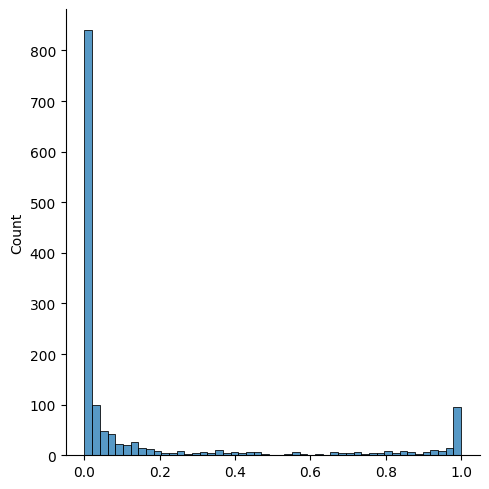

In [371]:
# sns.displot(y_pred, kde=False, rug=False)
sns.displot(y_pred, kde=False, rug=False)
plt.plot()

In [372]:
# Now that we have done the legwork, we can produce the desired confusion matrices.

# Create a sklearn confusion matrix
cm = confusion_matrix(test['Attrition'], prediction)
print ("Confusion Matrix : \n", cm)

# We also can use sklearn to calculate the overall accuracy of the model.  A flawed, but helpful metric.
print('Test accuracy = ', accuracy_score(test['Attrition'], prediction))

Confusion Matrix : 
 [[1180   42]
 [  32  175]]
Test accuracy =  0.9482155353393982


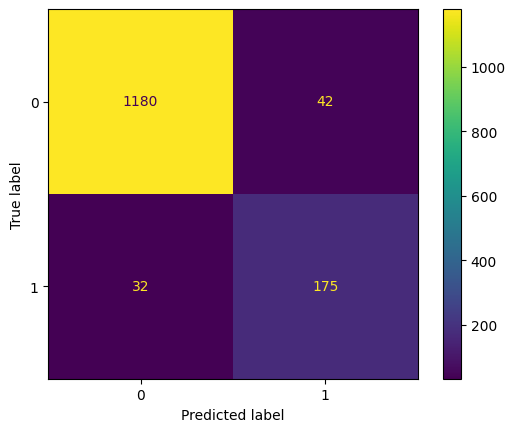

In [373]:
# Should we want a slightly more graphical display, sklearn also offers ConfusionMatrixDisplay()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [374]:
# Classification_report() has two required fields: the ground truth (y) and the binary predicted values (pred)

print(classification_report(test['Attrition'],prediction))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1222
           1       0.81      0.85      0.83       207

    accuracy                           0.95      1429
   macro avg       0.89      0.91      0.90      1429
weighted avg       0.95      0.95      0.95      1429



In [375]:
# First we use sklearn's roc_auc_score() function to find the area under the curve for our initial model. 
# Having calculated this value, we can then plot in on a graph along with our ROC curve.

auc=roc_auc_score(test['Attrition'],y_pred )
print(auc)

0.9780434387279899


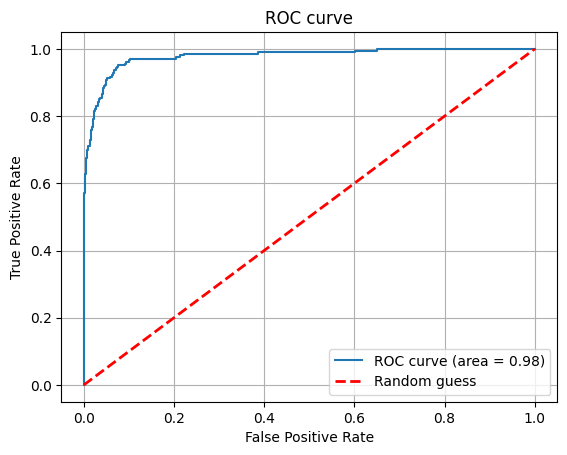

In [376]:
# Use Scikit-learn's ROC Curve Utility to plot ROC curve. For reference, we also include a 'line of determination (y=x)',
# which represents no lift from the model (just random guessing, the worst kind of model performance).
# Our goal is to produce a model that separates from the line of determination and captures as much of the area above the line
# as possible.

fpr, tpr, thresholds = roc_curve(test['Attrition'],  y_pred)

# Create ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend()
plt.show()

## What savings in employee acquisition/training could this initiative generate?

In [377]:
# Use test model data

# Average probability of attrition in the test data
mean_prob_test = y_pred.mean().round(2)
mean_prob_test

0.17

In [378]:
# Add change in initiative variable while controlling for others

log_reg_ext.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 3926
Model:                          Logit   Df Residuals:                     3915
Method:                           MLE   Df Model:                           10
Date:                Sat, 12 Aug 2023   Pseudo R-squ.:                  0.8045
Time:                        19:28:28   Log-Likelihood:                -510.63
converged:                       True   LL-Null:                       -2611.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.0344      0.090     -0.380      0.704      -0.211       0.143
MonthlyIncome_sd              -0.0434      0.080     -0.540      0.589      -0.201       0.114
TrainingTimesLastYear_sd      -0.1529      0.083     -1.834      0.067      -0.316       0.011
EnvironmentSatisfaction_sd    -0.8144      0.087     -9.348      0.000      -0.985      -0.644
WorkLifeBalance_sd            -1.9206      0.109    -17.663      0.000      -2.134      -1.708
JobSatisfaction_sd            -0.8927      0.085    -10.468      0.000      -1.060      -0.726
PercentSalaryHike_sd          -1.1250      0.111    -10.168      0.000      -1.342      -0.908
YearsWithCurrManager_sd       -0.5597      0.088     -6.352      0.000      -0.732      -0.387
DistanceFromHome_sd            0.7655      0.089      8.582      0.000       0.591       0.940
PerformanceRating_sd          -1.9881      0.134    -14.869      0.000      -2.250      -1.726
JobInvolvement_sd             -1.5673      0.106    -14.759      0.000      -1.775      -1.359
==============================================================================================

Possibly complete quasi-separation: A fraction 0.10 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

## Come back to this

In [285]:
from sklearn.preprocessing import StandardScaler

# First Standarize variable to be chnaged, and get mean and standard devation values
df = pd.read_csv("../data/df.csv",sep=",") # Load cleaned dataframe


scaler =  StandardScaler().fit(df[['TrainingTimesLastYear', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'JobSatisfaction']])

means = scaler.mean_
deviations = scaler.var_

# print(means, deviations)

In [303]:
X = df[['MonthlyIncome_sd', 'TrainingTimesLastYear_sd', 'EnvironmentSatisfaction_sd', 'WorkLifeBalance_sd', 'JobSatisfaction_sd',
    'PercentSalaryHike_sd', 'YearsWithCurrManager_sd' ,'DistanceFromHome_sd', 'PerformanceRating_sd', 'JobInvolvement_sd']].copy()

X['Intercept'] = 1

y = df['Attrition']

# Log odds of the average case

model = stats.Logit(y, X).fit()

# # Calculate the mean values for the input variables
# mean_values = X.mean()

# # Make a prediction using the mean values
# predicted_log_odds = model.predict(mean_values)

# # # Extract the confidence interval
# # conf_interval = predicted_log_odds.conf_int()

# y = intercept (all other values are multiplied by 0)

log_odds = model.params['Intercept'] # Mean of all other scaled values is 0, so all that is left is the intercept

print("Predicted Log Odds:", log_odds)

OR = np.exp(log_odds)

print("Predicted Odds Ratio:", OR)

probability = OR / (1+OR)

print("Predicted Probability of Attrition:" ,probability*100)



Optimization terminated successfully.
         Current function value: 0.126183
         Iterations 9
Predicted Log Odds: -4.143759350877424
Predicted Odds Ratio: 0.015863104294466225
Predicted Probability of Attrition: 1.5615395644754138


In [305]:
# Plug in value to stardized formula
# | standardized_value = (value - mean) / standard_deviation
# |# y = intercept + coef*variable_std


# Effect of increase work_life by 0.3
variable = 2
work_life_option = 0.3 - means[variable] / deviations[variable]
work_life_option

# new_X_mean = X.mean().copy()
# new_X_mean['WorkLifeBalance_sd'] = work_life_option

# # Make a prediction using the mean values
# new_predicted_log_odds = model.predict(new_X_mean)

# # Extract the confidence interval
# conf_interval = predicted_log_odds.conf_int()

print("Predicted Log Odds:", new_predicted_log_odds.values)

New_OR = np.exp(new_predicted_log_odds.values)

print("Predicted Odds Ratio:", New_OR)

New_prob = New_OR / (1+New_OR)

print("Predicted Probability of Attrition:" ,New_prob)




Predicted Log Odds: [0.74988612]
Predicted Odds Ratio: [2.11675895]
Predicted Probability of Attrition: [0.67915388]


In [ ]:
# Interpret the change in numbers of employees and total costs

In [ ]:
### EXTRA

In [ ]:
# from sklearn.inspection import permutation_importance
# # Fit a model 

# model = LogisticRegression(random_state = SEED, max_iter = 1000, n_jobs = -1)
# model.fit(X_train, y_train)

# X_train = train.drop(columns='Attrition')
# y_train = train['Attrition']

# X_test = test.drop(columns='Attrition')
# y_test = test['Attrition']

# # Calculate permutation importance
# result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=SEED, scoring = 'f1', njobs = -1)

# # Print feature importance scores
# print("Permutation Importance:\n", result.importances_mean)
